In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
from collections import OrderedDict
from utils.utils import data_preprocess, data_process, runmodel, viz
from utils.Qmodels  import QRegressionLSTM, QLSTM
import seaborn as sb
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
batch_size = 4
learning_rate = 0.004
num_epochs = 10
device = "cpu"

In [5]:
df = pd.read_csv('./Data/Weather_NY.csv')
df

,pickup_datetime,tempm,tempi,dewptm,dewpti,hum,wspdm,wspdi,wgustm,wgusti,...,precipm,precipi,conds,icon,fog,rain,snow,hail,thunder,tornado
0,2015-12-31 00:15:00,7.8,46.0,6.1,43.0,89.0,7.4,4.6,NaN,NaN,...,0.5,0.02,Light Rain,rain,0,1,0,0,0,0
1,2015-12-31 00:42:00,7.8,46.0,6.1,43.0,89.0,7.4,4.6,NaN,NaN,...,0.8,0.03,Overcast,cloudy,0,0,0,0,0,0
2,2015-12-31 00:51:00,7.8,46.0,6.1,43.0,89.0,5.6,3.5,NaN,NaN,...,0.8,0.03,Overcast,cloudy,0,0,0,0,0,0
3,2015-12-31 01:51:00,7.2,45.0,5.6,42.1,90.0,7.4,4.6,NaN,NaN,...,0.3,0.01,Overcast,cloudy,0,0,0,0,0,0
4,2015-12-31 02:51:00,7.2,45.0,5.6,42.1,90.0,0.0,0.0,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10476,2016-12-31 19:51:00,6.1,43.0,-4.4,24.1,47.0,7.4,4.6,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0
10477,2016-12-31 20:51:00,6.1,43.0,-4.4,24.1,47.0,13.0,8.1,38.9,24.2,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0
10478,2016-12-31 21:51:00,6.1,43.0,-5.0,23.0,45.0,9.3,5.8,29.6,18.4,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0
10479,2016-12-31 22:51:00,6.7,44.1,-5.0,23.0,43.0,14.8,9.2,NaN,NaN,...,NaN,NaN,Overcast,cloudy,0,0,0,0,0,0


In [6]:
dfi = df.loc[df['pickup_datetime'] > '2016-08-01']
dfi = dfi[['pressurem','tempm','hum','dewptm']]
dfi = dfi.dropna()
dfi = dfi.reset_index(drop=True)
dfi

,pressurem,tempm,hum,dewptm
0,1022.2,6.1,62.0,-0.6
1,1021.6,6.1,62.0,-0.6
2,1021.7,6.1,68.0,0.6
3,1021.5,6.7,65.0,0.6
4,1022.6,6.7,65.0,0.6
...,...,...,...,...
4240,1013.8,6.1,47.0,-4.4
4241,1012.9,6.1,47.0,-4.4
4242,1012.5,6.1,45.0,-5.0
4243,1012.4,6.7,43.0,-5.0


<Axes: >

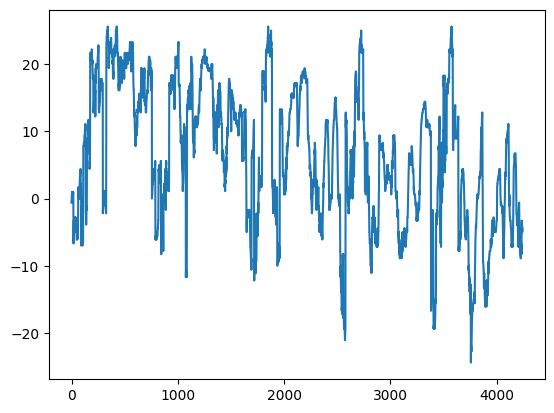

In [8]:
dfi['dewptm'].plot()

In [9]:
X_train, X_test, y_train, y_test, train_target_scalar, train_scaler, test_target_scalar, test_scaler = data_preprocess(src='./Data/london_weather.csv', city=None,datetime=20080000,date_column='date',datemore='yes',
                    imp_columns=['sunshine','max_temp','pressure','precipitation'], target='precipitation')

/teamspace/studios/this_studio/other_models/utils/utils.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfi['nxt_target'][len(dfi)-1] = dfi['nxt_target'][len(dfi)-2]


# QLSTM

In [10]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQLSTM = QRegressionLSTM(num_sensors=4, hidden_units= 12, n_qubits=4)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQLSTM.parameters(), lr = learning_rate, betas = (0.0, 0.9))

weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [11]:
for param in modelQLSTM.parameters():
    print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([4, 16])
<class 'torch.Tensor'> torch.Size([4])
<class 'torch.Tensor'> torch.Size([12, 4])
<class 'torch.Tensor'> torch.Size([12])
<class 'torch.Tensor'> torch.Size([1, 12])
<class 'torch.Tensor'> torch.Size([1])


In [14]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQLSTM.zero_grad()
        x = x.to(device)
        y = y.to(device)
        
        output = modelQLSTM(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        #print(lossQ)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
        
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)}')

[1/5]  LossQ:nan
[2/5]  LossQ:nan
[3/5]  LossQ:nan
[4/5]  LossQ:nan
[5/5]  LossQ:nan


In [13]:
histQ = runmodel(modelQLSTM,trainDataloader,num_epochs,device,criterion,optimizerQ)

[1/5]  LossQ:nan


KeyboardInterrupt: 

In [ ]:
viz(histQ,modelQLSTM,X_test,X_train,y_test,y_train,train_target_scalar,test_target_scalar)